In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#  Import additional libraries for missing value handling strategies
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.interpolate import interp1d
import joblib

In [16]:
class HumanActivityDataset:
    def __init__(self, root_path):
        """
        Initialize the dataset with the root path
        
        Parameters:
        root_path (str): Root path containing 'LS' and 'TS' folders
        """
        self.root_path = root_path
        self.learning_set_path = os.path.join(root_path, 'LS')
        self.test_set_path = os.path.join(root_path, 'TS')
        
    def load_dataset(self, dataset_type='learning'):
        """
        Load sensor data, activities, and subject IDs
        
        Parameters:
        dataset_type (str): 'learning' or 'test'
        
        Returns:
        tuple: Sensors dictionary, activities array (None for test set), subjects array
        """
        # Choose the correct path
        path = self.learning_set_path if dataset_type == 'learning' else self.test_set_path
        
        # Dictionary to store sensor data
        sensors = {}
        
        # Load data for each sensor
        for i in range(2, 33):  # Sensors from ID 2 to 32
            sensor_file = os.path.join(path, f'LS_sensor_{i}.txt' if dataset_type == 'learning' else f'TS_sensor_{i}.txt')
            sensors[i] = np.loadtxt(sensor_file)
        
        # Load subject IDs
        subjects = np.loadtxt(os.path.join(path, 'subject_Id.txt'))
        
        # Load activities for learning set
        activities = None
        if dataset_type == 'learning':
            activities = np.loadtxt(os.path.join(path, 'activity_Id.txt'))
        
        return sensors, activities, subjects
    
    def analyze_missing_values(self, sensors):
        """
        Analyze missing values across all sensors
        
        Parameters:
        sensors (dict): Dictionary of sensor data
        
        Returns:
        dict: Missing value statistics for each sensor
        """
        missing_stats = {}
        
        for sensor_id, sensor_data in sensors.items():
            # Count completely missing samples and missing points
            missing_samples = np.sum(np.all(sensor_data == -999999.99, axis=1))
            missing_points = np.sum(sensor_data == -999999.99)
            total_points = sensor_data.size
            
            missing_stats[sensor_id] = {
                'total_samples': sensor_data.shape[0],
                'completely_missing_samples': missing_samples,
                'missing_points': missing_points,
                'missing_percentage': (missing_points / total_points) * 100
            }
        
        return missing_stats
    
    def visualize_sensor_characteristics(self, sensors, activities):
        """
        Create comprehensive visualizations of sensor data
        
        Parameters:
        sensors (dict): Dictionary of sensor data
        activities (array): Activity labels
        """
        # Activity names for reference
        activity_names = [
            'Lying', 'Sitting', 'Standing', 'Walking very slow', 'Normal walking', 
            'Nordic walking', 'Running', 'Ascending stairs', 'Descending stairs', 
            'Cycling', 'Ironing', 'Vacuum cleaning', 'Rope jumping', 'Playing soccer'
        ]
        
        # Select representative sensors from different body locations
        selected_sensors = {
            'Heart Rate': 2, 
            'Hand Acceleration': 4, 
            'Chest Temperature': 13, 
            'Foot Acceleration': 24, 
            'Foot Magnetometer': 30
        }
        
        # Create a multi-panel figure
        fig, axes = plt.subplots(len(selected_sensors), 1, figsize=(15, 20))
        fig.suptitle('Sensor Data Across Different Activities', fontsize=16)
        
        for i, (sensor_name, sensor_id) in enumerate(selected_sensors.items()):
            sensor_data = sensors[sensor_id]
            
            # Mask missing values
            masked_data = np.ma.masked_equal(sensor_data, -999999.99)
            
            # Box plot of sensor values by activity
            box_data = []
            for activity in range(1, 15):
                activity_data = masked_data[activities == activity]
                # Take mean of each sample to reduce dimensionality
                box_data.append(np.mean(activity_data, axis=1))
            
            axes[i].boxplot(box_data, labels=[activity_names[j-1] for j in range(1, 15)])
            axes[i].set_title(f'{sensor_name} (Sensor {sensor_id})')
            axes[i].set_xlabel('Activities')
            axes[i].set_ylabel('Average Sensor Value')
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    # def preprocess_sensors(self, sensors):
    #     """
    #     Preprocess sensor data by handling missing values and standardizing
        
    #     Parameters:
    #     sensors (dict): Dictionary of sensor data
        
    #     Returns:
    #     dict: Preprocessed sensor data
    #     """
    #     preprocessed_sensors = {}
        
    #     # Store scaler for each sensor
    #     scalers = {}
    #     for sensor_id, sensor_data in sensors.items():
    #         # Create a copy of the data
    #         processed_data = sensor_data.copy()
            
    #         # Replace missing values with median for each sample
    #         for i in range(processed_data.shape[0]):
    #             sample = processed_data[i]
    #             valid_values = sample[sample != -999999.99]
                
    #             if len(valid_values) > 0:
    #                 # Replace missing values with sample median
    #                 processed_data[i][sample == -999999.99] = np.median(valid_values)
    #             else:
    #                 # If all values are missing, replace with 0
    #                 processed_data[i][sample == -999999.99] = 0
            
    #         # Standardize each sensor's data
    #         scalers[sensor_id] = StandardScaler()
    #         preprocessed_sensors[sensor_id] = scalers[sensor_id].fit_transform(processed_data)
        
    #     return preprocessed_sensors, scalers
    
    def detect_outliers(self, sensors):
        outliers_stats = {}

        for sensor_id, data in sensors.items():
            Q1 = np.percentile(data, 25)
            Q3 = np.percentile(data, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outliers_percentage = (len(outliers) / data.size) * 100
            outliers_stats[sensor_id] = outliers_percentage
        return outliers_stats

    def explore_dataset(self):
        """
        Comprehensive exploration of the Human Activity Recognition dataset

        Returns:
        dict: Containing raw and preprocessed sensor data, activities, and subjects
        """
        # Load learning dataset
        learning_sensors, activities, learning_subjects = self.load_dataset('learning')

        # Load test dataset
        test_sensors, _, test_subjects = self.load_dataset('test')

        # Analyze missing values for learning set
        print("Missing Value Statistics (Learning Set):")
        learning_missing_stats = self.analyze_missing_values(learning_sensors)
        for sensor_id, stats in learning_missing_stats.items():
            print(f"Sensor {sensor_id}: {stats} missing values")

        # Detect outliers in learning set
        print("\nOutlier Statistics (Learning Set):")
        learning_outliers_stats = self.detect_outliers(learning_sensors)
        for sensor_id, outliers_percentage in learning_outliers_stats.items():
            print(f"Sensor {sensor_id}: {outliers_percentage:.2f}% outliers detected")

        # Visualize sensor characteristics for learning set
        self.visualize_sensor_characteristics(learning_sensors, activities)

        # Return key information for further analysis
        return {
            'learning_raw_sensors': learning_sensors,
            'learning_activities': activities,
            'learning_subjects': learning_subjects,
            'test_raw_sensors': test_sensors,
            'test_subjects': test_subjects
        }


Missing Value Statistics (Learning Set):
Sensor 2: {'total_samples': 3500, 'completely_missing_samples': 0, 'missing_points': 0, 'missing_percentage': 0.0} missing values
Sensor 3: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage': 4.66796875} missing values
Sensor 4: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage': 4.66796875} missing values
Sensor 5: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage': 4.66796875} missing values
Sensor 6: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage': 4.66796875} missing values
Sensor 7: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage': 4.66796875} missing values
Sensor 8: {'total_samples': 3500, 'completely_missing_samples': 160, 'missing_points': 83650, 'missing_percentage'

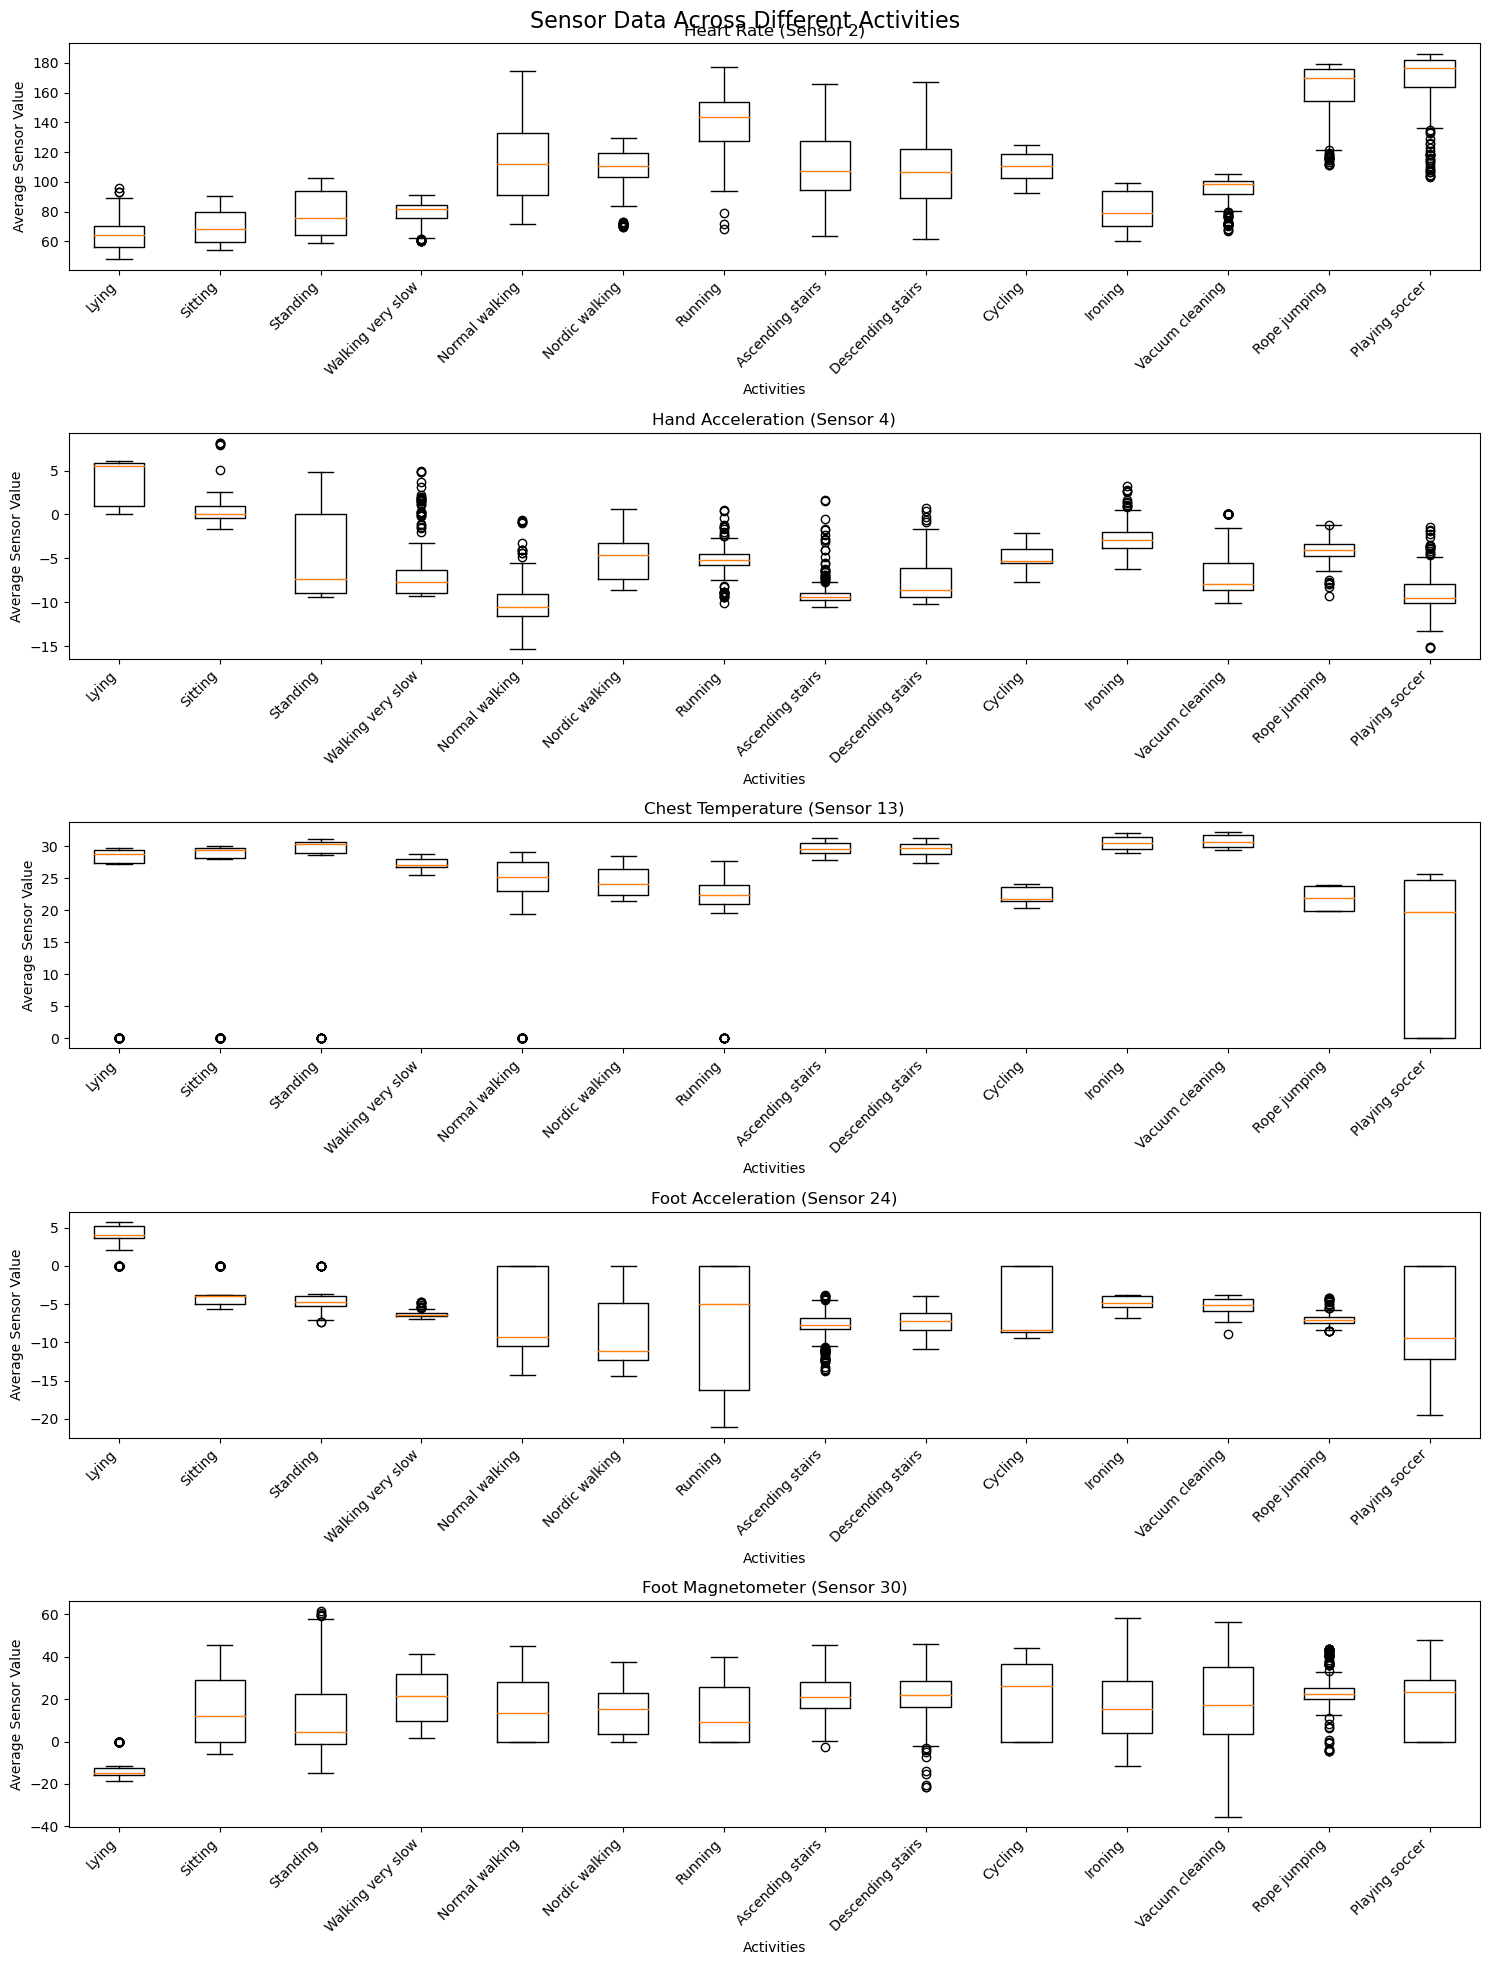

In [17]:
dataset_explorer = HumanActivityDataset('.')

# Explore the dataset
dataset = dataset_explorer.explore_dataset()

# Create Missing Value Handlers
Create a class that inherits from HumanActivityDataset to implement different imputation strategies (mean, mode, knn, interpolation)



In [ ]:
# Create a class that inherits from HumanActivityDataset to implement different imputation strategies
class HumanActivityDatasetWithImputation(HumanActivityDataset):
    def __init__(self, root_path):
        super().__init__(root_path)
    
    def mean_imputation(self, sensors):
        imputed_sensors = {}
        scalers = {}
        for sensor_id, sensor_data in sensors.items():
            imputer = SimpleImputer(strategy='mean')
            imputed_data = imputer.fit_transform(sensor_data)
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(imputed_data)
            imputed_sensors[sensor_id] = scaled_data
            scalers[sensor_id] = scaler
        return imputed_sensors, scalers
    
    def mode_imputation(self, sensors):
        imputed_sensors = {}
        scalers = {}
        for sensor_id, sensor_data in sensors.items():
            imputer = SimpleImputer(strategy='most_frequent')
            imputed_data = imputer.fit_transform(sensor_data)
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(imputed_data)
            imputed_sensors[sensor_id] = scaled_data
            scalers[sensor_id] = scaler
        return imputed_sensors, scalers
    
    def knn_imputation(self, sensors, n_neighbors=5):
        imputed_sensors = {}
        scalers = {}
        for sensor_id, sensor_data in sensors.items():
            imputer = KNNImputer(n_neighbors=n_neighbors)
            imputed_data = imputer.fit_transform(sensor_data)
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(imputed_data)
            imputed_sensors[sensor_id] = scaled_data
            scalers[sensor_id] = scaler
        return imputed_sensors, scalers
    
    def linear_interpolation(self, sensors):
        imputed_sensors = {}
        scalers = {}
        for sensor_id, sensor_data in sensors.items():
            imputed_data = sensor_data.copy()
            for i in range(imputed_data.shape[1]):
                col = imputed_data[:, i]
                mask = col != -999999.99
                if np.any(mask):
                    interp_func = interp1d(np.where(mask)[0], col[mask], bounds_error=False, fill_value="extrapolate")
                    col[~mask] = interp_func(np.where(~mask)[0])
                imputed_data[:, i] = col
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(imputed_data)
            imputed_sensors[sensor_id] = scaled_data
            scalers[sensor_id] = scaler
        return imputed_sensors, scalers

['.\\LS\\linear_scalers.pkl']

In [ ]:
# Initialize the dataset explorer with imputation strategies
dataset_explorer_imputation = HumanActivityDatasetWithImputation('.')

# Load the learning dataset
learning_sensors, activities, learning_subjects = dataset_explorer_imputation.load_dataset('learning')

# Apply different imputation strategies
mean_imputed_sensors, mean_scalers = dataset_explorer_imputation.mean_imputation(learning_sensors)
mode_imputed_sensors, mode_scalers = dataset_explorer_imputation.mode_imputation(learning_sensors)
knn_imputed_sensors, knn_scalers = dataset_explorer_imputation.knn_imputation(learning_sensors)
linear_imputed_sensors, linear_scalers = dataset_explorer_imputation.linear_interpolation(learning_sensors)

# Save the imputed datasets and scalers
joblib.dump(mean_imputed_sensors, os.path.join(dataset_explorer_imputation.learning_set_path, 'mean_imputed_sensors.pkl'))
joblib.dump(mean_scalers, os.path.join(dataset_explorer_imputation.learning_set_path, 'mean_scalers.pkl'))
joblib.dump(mode_imputed_sensors, os.path.join(dataset_explorer_imputation.learning_set_path, 'mode_imputed_sensors.pkl'))
joblib.dump(mode_scalers, os.path.join(dataset_explorer_imputation.learning_set_path, 'mode_scalers.pkl'))
joblib.dump(knn_imputed_sensors, os.path.join(dataset_explorer_imputation.learning_set_path, 'knn_imputed_sensors.pkl'))
joblib.dump(knn_scalers, os.path.join(dataset_explorer_imputation.learning_set_path, 'knn_scalers.pkl'))
joblib.dump(linear_imputed_sensors, os.path.join(dataset_explorer_imputation.learning_set_path, 'linear_imputed_sensors.pkl'))
joblib.dump(linear_scalers, os.path.join(dataset_explorer_imputation.learning_set_path, 'linear_scalers.pkl'))

### Why We Impute with Different Methods

Imputation is the process of replacing missing data with substituted values. Different imputation methods are used to handle missing data in various ways:

- **Mean Imputation**: Replaces missing values with the mean of the available values. This method is simple and effective when the data is symmetrically distributed.
- **Mode Imputation**: Replaces missing values with the most frequent value (mode). This is useful for categorical data or when the data has a high frequency of certain values.
- **KNN Imputation**: Uses the k-nearest neighbors algorithm to impute missing values based on the values of the nearest neighbors. This method can capture the local structure of the data.
- **Linear Interpolation**: Estimates missing values by fitting a linear function to the available data points. This method is useful when the data follows a linear trend.

Using different imputation methods allows us to compare their effectiveness and choose the best approach for our specific dataset.

### Why We Use .pkl Files and How to Work with Them

`.pkl` files are used to serialize Python objects using the `pickle` module. Serialization is the process of converting an object into a byte stream, which can be saved to a file and later deserialized to reconstruct the original object. We use `.pkl` files for the following reasons:

- **Efficiency**: Pickle files are efficient for saving and loading complex data structures, such as dictionaries and lists.
- **Convenience**: They allow us to save the state of an object, such as a trained model or preprocessed data, and load it later without having to recompute or retrain.
- **Portability**: Pickle files can be easily shared and used across different environments.

To work with `.pkl` files, we use the `joblib` library, which provides efficient serialization for large numpy arrays and other data structures:

```python
import joblib

# Save an object to a .pkl file
joblib.dump(object, 'filename.pkl')

# Load an object from a .pkl file
object = joblib.load('filename.pkl')
```

### Why We Standardize the Values and Why We Are Saving the Scalers for Later

Standardization is the process of scaling data to have a mean of 0 and a standard deviation of 1. This is important for the following reasons:

- **Consistency**: Standardizing ensures that all features contribute equally to the analysis, preventing features with larger scales from dominating. We indeed have very different metrics (BPM vs C°)
- **Improved Performance**: Many machine learning algorithms perform better when the data is standardized, as it helps with convergence and stability during training.
- **Comparability**: Standardized data allows for easier comparison between different features and datasets.

We save the scalers for later use to ensure that the same transformation is applied to new data, such as test data or future data points. This maintains consistency and allows us to accurately compare and evaluate the performance of our models:

```python
from sklearn.preprocessing import StandardScaler
import joblib

# Fit and transform the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Load the scaler and transform new data
scaler = joblib.load('scaler.pkl')
new_scaled_data = scaler.transform(new_data)
```

# Compare Imputation Methods
Show statistics to compare how different imputation methods handle the missing values

In [ ]:
# Compare Imputation Methods

# Create visualizations and statistics to compare how different imputation methods handle the missing values

# Function to visualize imputed data
def visualize_imputed_data(imputed_sensors, title):
    fig, axes = plt.subplots(5, 1, figsize=(15, 25))
    fig.suptitle(title, fontsize=16)
    selected_sensors = [2, 4, 13, 24, 30]  # Example sensor IDs
    for i, sensor_id in enumerate(selected_sensors):
        sensor_data = imputed_sensors[sensor_id]
        axes[i].plot(sensor_data)
        axes[i].set_title(f'Sensor {sensor_id}')
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Value')
    plt.tight_layout()
    plt.show()

# # Visualize mean imputed data
# visualize_imputed_data(mean_imputed_sensors, 'Mean Imputation')

# # Visualize mode imputed data
# visualize_imputed_data(mode_imputed_sensors, 'Mode Imputation')

# # Visualize k-NN imputed data
# visualize_imputed_data(knn_imputed_sensors, 'k-NN Imputation')

# # Visualize linear interpolation imputed data
# visualize_imputed_data(linear_imputed_sensors, 'Linear Interpolation')

# Function to calculate and print statistics for imputed data
def print_imputation_statistics(imputed_sensors, method_name):
    print(f"Statistics for {method_name}:")
    for sensor_id, sensor_data in imputed_sensors.items():
        mean_value = np.mean(sensor_data)
        std_dev = np.std(sensor_data)
        print(f"Sensor {sensor_id}: Mean = {mean_value}, Std Dev = {std_dev}")

# Print statistics for mean imputed data
print_imputation_statistics(mean_imputed_sensors, 'Mean Imputation')

# Print statistics for mode imputed data
print_imputation_statistics(mode_imputed_sensors, 'Mode Imputation')

# Print statistics for k-NN imputed data
print_imputation_statistics(knn_imputed_sensors, 'k-NN Imputation')

# Print statistics for linear interpolation imputed data
print_imputation_statistics(linear_imputed_sensors, 'Linear Interpolation')

Statistics for Mean Imputation:
Sensor 2: Mean = 1.2751704454266083e-17, Std Dev = 0.9999999999999998
Sensor 3: Mean = -1.9933261390698524e-16, Std Dev = 0.9999999999999997
Sensor 4: Mean = -2.7279765747932418e-17, Std Dev = 1.0
Sensor 5: Mean = -5.938107148852265e-17, Std Dev = 1.0
Sensor 6: Mean = -2.6645352591003756e-17, Std Dev = 1.0
Sensor 7: Mean = -1.423623124147915e-16, Std Dev = 0.9999999999999998
Sensor 8: Mean = 1.088652977289582e-16, Std Dev = 0.9999999999999997
Sensor 9: Mean = -1.3386117611194745e-16, Std Dev = 1.0
Sensor 10: Mean = -5.252940939369312e-17, Std Dev = 0.9999999999999998
Sensor 11: Mean = -4.491645151054919e-17, Std Dev = 1.0
Sensor 12: Mean = -4.314009467114894e-16, Std Dev = 0.9999999999999999
Sensor 13: Mean = 7.638334409421077e-16, Std Dev = 1.0
Sensor 14: Mean = 5.128595960611294e-16, Std Dev = 0.9999999999999999
Sensor 15: Mean = 8.256252824269593e-16, Std Dev = 0.9999999999999997
Sensor 16: Mean = 8.092574229781998e-16, Std Dev = 1.0000000000000004
Se

## Suggestions

We have several sensors that could be combined as they represent values on a 3D scale.